In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unet-model/UNet.h5
/kaggle/input/brats-2021-task1/BraTS2021_00495.tar
/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar
/kaggle/input/brats-2021-task1/BraTS2021_00621.tar


In [3]:
import numpy as np
import math
import random
import os
import shutil
import gzip
import glob
import gc
import cv2 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import tarfile
import PIL
import scipy.misc
import skimage
import nibabel as nib

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
from PIL import Image
from tqdm import tqdm
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers 
from keras import backend as K
from sklearn.model_selection import train_test_split
from scipy import ndimage as ndi
from glob import glob

In [5]:
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K 
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Activation,
    Conv3D,
    Conv3DTranspose,
    MaxPooling3D,
    UpSampling3D,
)
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, regularizers

DEVICE = "GPU"

In [6]:
# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

In [7]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Using default strategy for CPU and single GPU
Num GPUs Available:  1
REPLICAS: 1


In [8]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# soft dice loss 
def soft_dice_loss(y_true, y_pred, epsilon=1e-6): 

    
    # skip the batch and class axis for calculating Dice score
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * np.sum(y_pred * y_true, axes)
    denominator = np.sum(np.square(y_pred) + np.square(y_true), axes)
    
    return 1 - np.mean((numerator + epsilon) / (denominator + epsilon)) # average over classes and batch

#intersection over union
def iou(y_true, y_pred, smooth = 0.5):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
metrics = [f1_score, specificity, sensitivity, iou, soft_dice_loss, dice_coef, dice_coef_loss ]

In [9]:
epochs = 10

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
# red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)


earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=epochs,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)
csv_logger = CSVLogger('Model.log')

callbacks = [earlystop, csv_logger, reduce_lr]

In [10]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',   
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_SIZE=128

In [11]:
import tarfile
file = tarfile.open('../input/brats-2021-task1/BraTS2021_Training_Data.tar')

file.extractall('./BraTS2021_Training_Data')
file.close()

file = tarfile.open('../input/brats-2021-task1/BraTS2021_00621.tar')

file.extractall('./sample_img')
file.close()

nSample = os.listdir('./sample_img')
nSample

['BraTS2021_00621_seg.nii.gz',
 'BraTS2021_00621_flair.nii.gz',
 'BraTS2021_00621_t2.nii.gz',
 'BraTS2021_00621_t1ce.nii.gz',
 'BraTS2021_00621_t1.nii.gz']

In [12]:
TRAIN_DATASET_PATH = './BraTS2021_Training_Data/'

In [12]:
nSample = os.listdir(TRAIN_DATASET_PATH + 'BraTS2021_01261')
nSample

['BraTS2021_01261_t1.nii.gz',
 'BraTS2021_01261_seg.nii.gz',
 'BraTS2021_01261_t1ce.nii.gz',
 'BraTS2021_01261_flair.nii.gz',
 'BraTS2021_01261_t2.nii.gz']

In [41]:
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00204/BraTS2021_00204_flair.nii.gz').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00204/BraTS2021_00204_t1.nii.gz').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00204/BraTS2021_00204_t1ce.nii.gz').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00204/BraTS2021_00204_t2.nii.gz').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_00204/BraTS2021_00204_seg.nii.gz').get_fdata()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 2., 2., 2., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 2., 2., 2.,
       2., 2., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

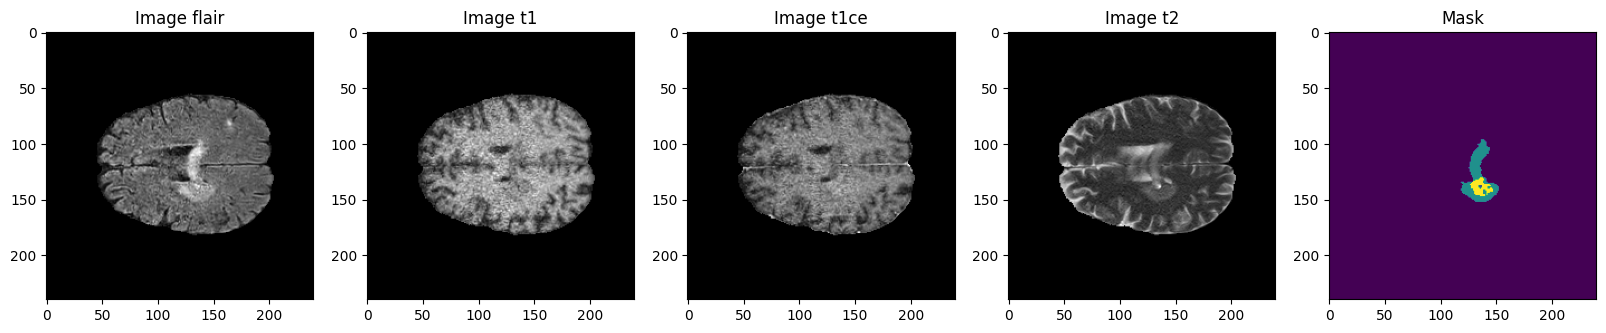

In [45]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')
test_mask[140][140]

In [15]:
from skimage.transform import rotate
from skimage.transform import resize
from skimage.util import montage

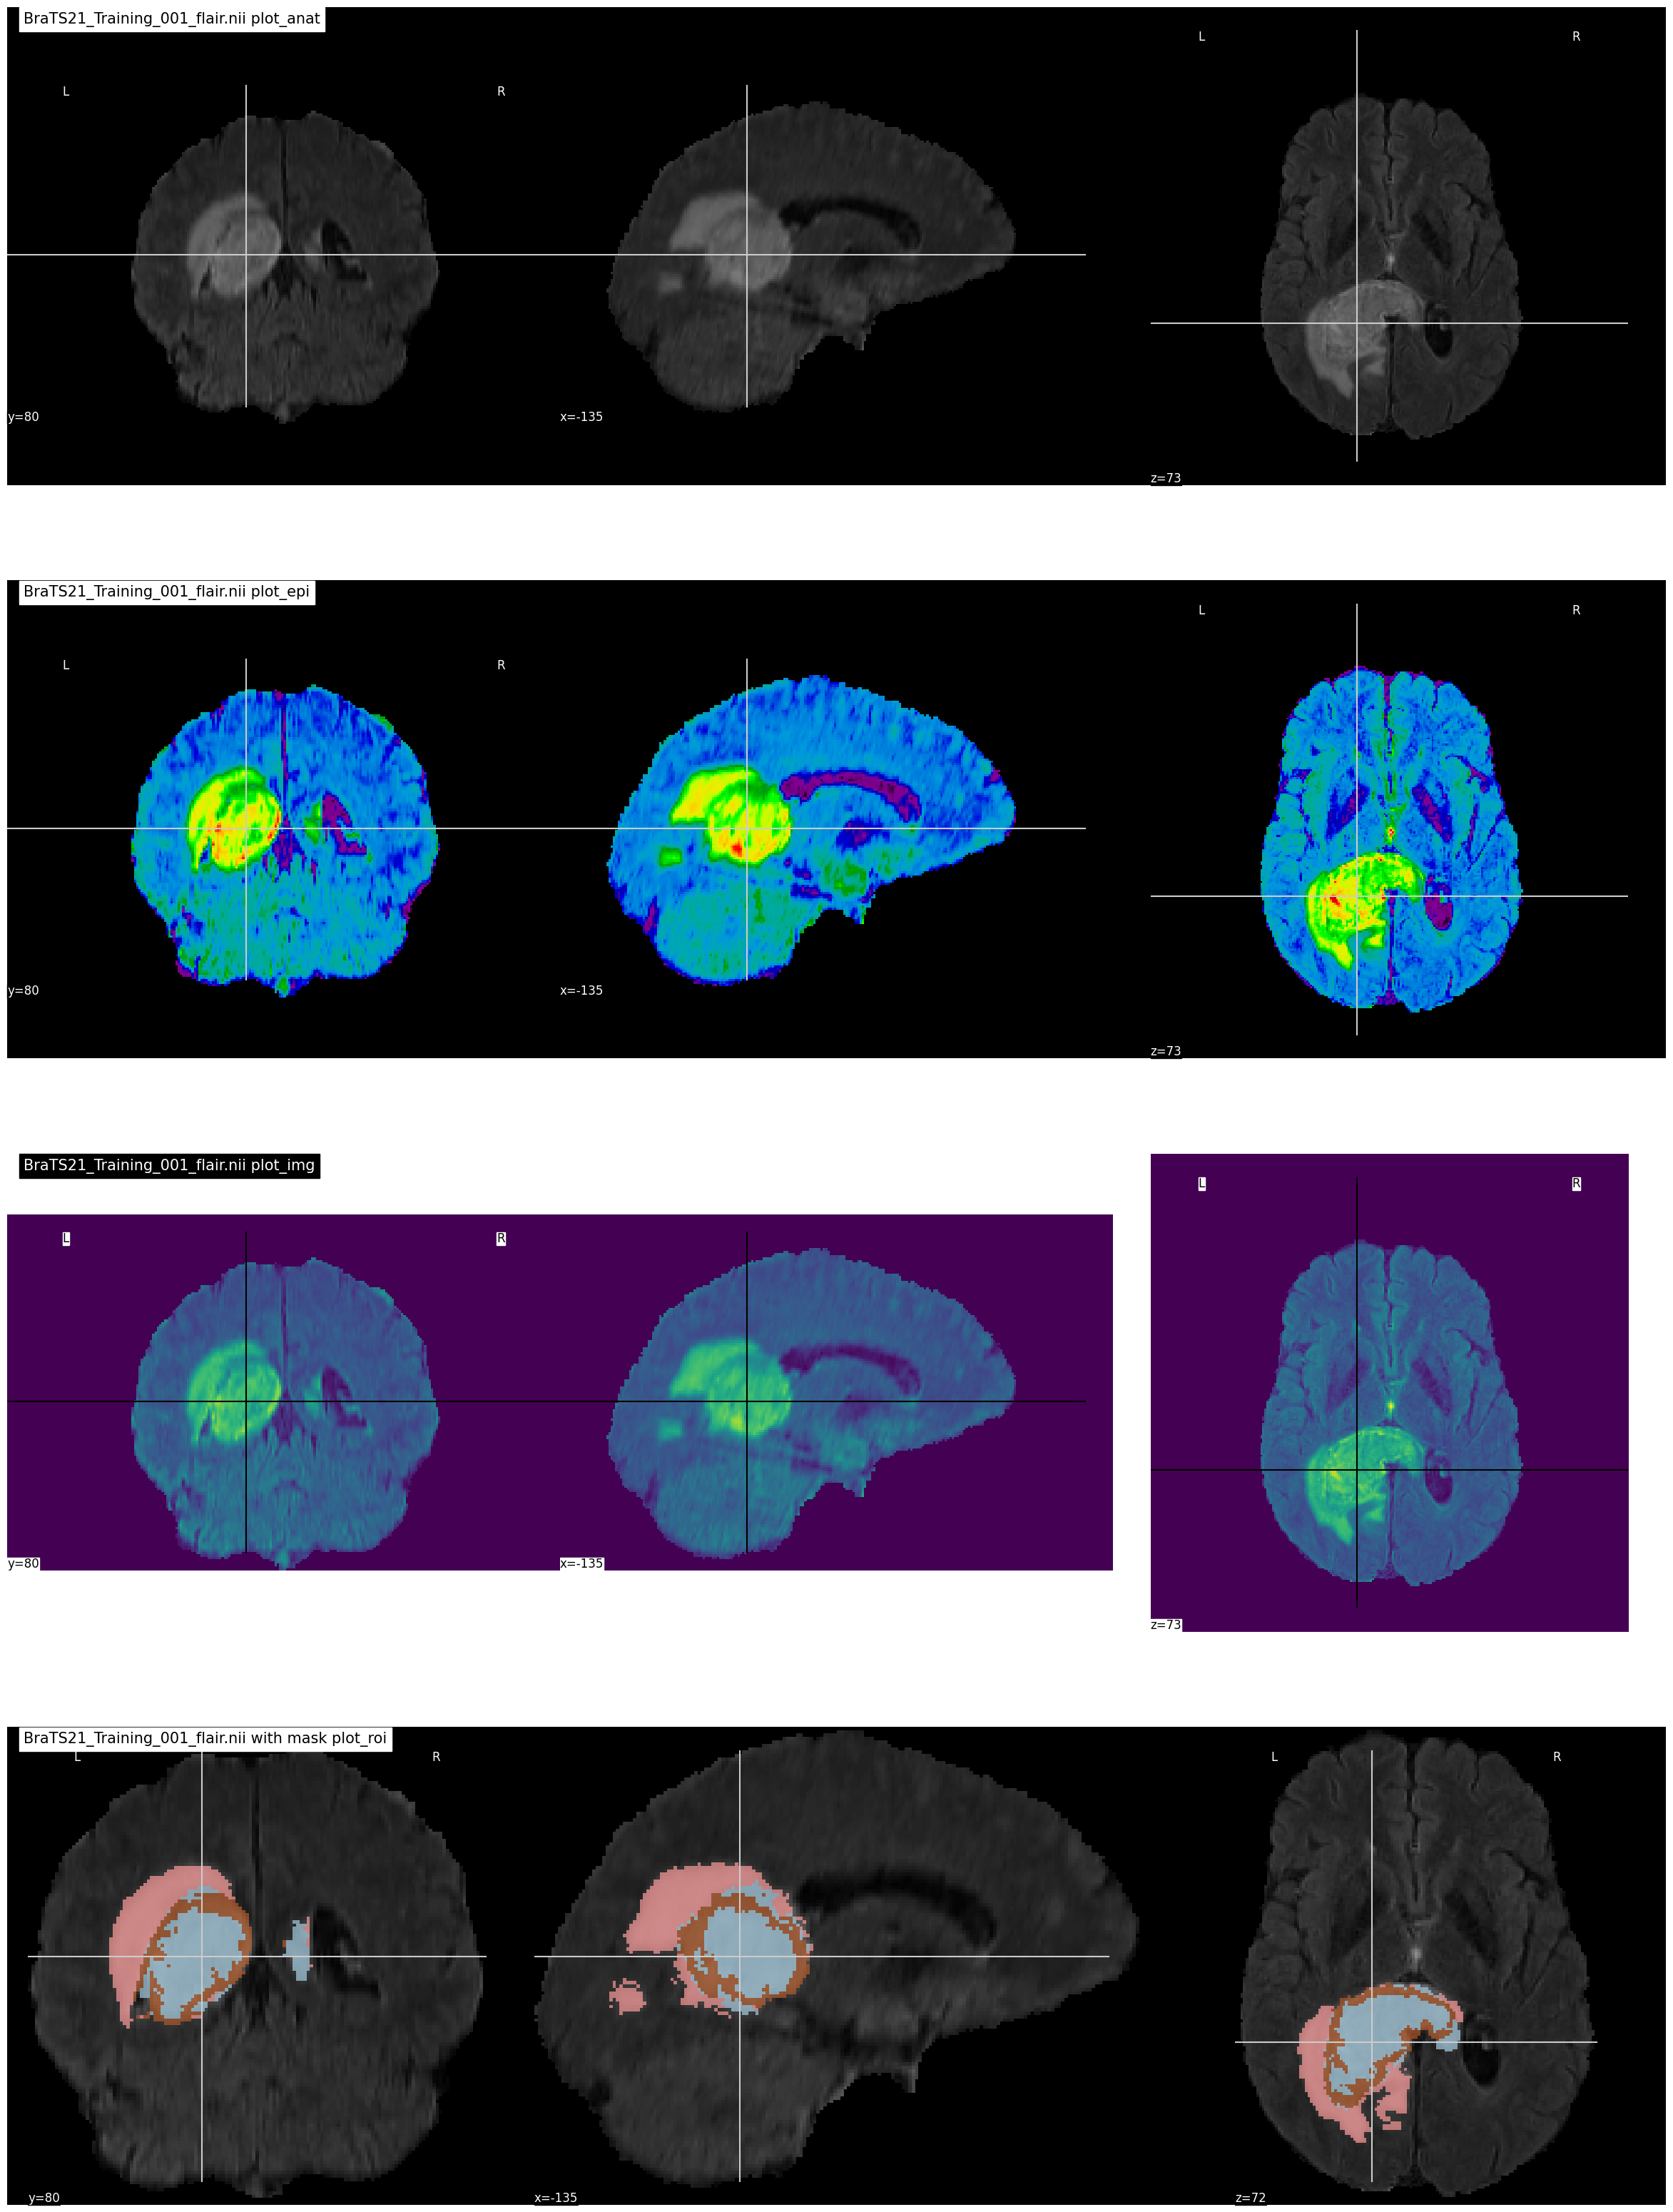

In [16]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_flair.nii.gz')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_seg.nii.gz')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS21_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS21_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS21_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS21_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [14]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
#train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [15]:
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_SIZE=128

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

850
251
150


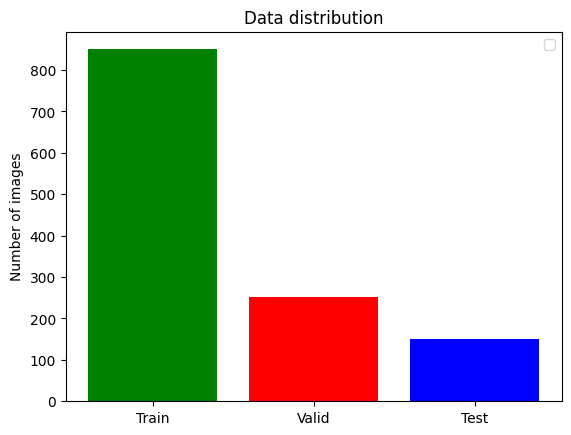

In [19]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')
    plt.savefig('data2018.png')
    plt.show()

print(len(train_ids))
print(len(val_ids))
print(len(test_ids))
showDataLayout()

In [20]:
def conv_block(inputs, filters, kernel_size=3):
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding="same")(x)
    
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

def encoder_block(inputs, filters, kernel_size=3):
    x = conv_block(inputs, filters, kernel_size)
    x = conv_block(inputs, filters, kernel_size)
    #x = tf.keras.layers.Dropout(0.3)
    skip_connection = x
    x = MaxPooling2D(pool_size=(2, 2))(x)
    return x, skip_connection


def decoder_block(inputs, skip_connection, filters, kernel_size=3):
    x = Conv2DTranspose(filters, (2, 2), strides=(2, 2))(inputs)
    x = concatenate([x, skip_connection], axis=3)
    x = conv_block(x, filters, kernel_size)
    return x

In [21]:
def build_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    enc1, skip1 = encoder_block(inputs, 16)
    enc2, skip2 = encoder_block(enc1, 32)
    enc3, skip3 = encoder_block(enc2, 64)


    # Bridge
    bridge = conv_block(enc3, 128)
    

    # Decoder
    dec3 = decoder_block(bridge, skip3, 64)
    dec2 = decoder_block(dec3, skip2, 32)
    dec1 = decoder_block(dec2, skip1, 16)
    
    
    # Output
    output = Conv2D(4, 1, activation="softmax")(dec1)

    model = Model(inputs = inputs, outputs = output)
    return model

In [22]:
K.clear_session()
# Create the U-Net++ model
input_shape = (128, 128, 2)  # Adjust the number of channels according to the data
model = build_model(input_shape)
model.compile(loss="categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
            metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes = 4),tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),tf.keras.metrics.AUC(name='AUC'),
                       f1_score, specificity, sensitivity, iou, dice_coef, dice_coef_loss ] )

print(model.input_shape)
print(model.output_shape)
#model.summary()



(None, 128, 128, 2)
(None, 128, 128, 4)


In [23]:
# %%time
history =  model.fit(training_generator,
                        batch_size = 16,
                        epochs = 10,
                        verbose="auto",
                        steps_per_epoch=len(train_ids),
                        callbacks = callbacks ,
                        validation_data = valid_generator) 

In [24]:
model.save("UNet++.h5")
print('Model save to Disk')

In [25]:
import pandas as pd
df = pd.DataFrame(history.history) 
# df.to_excel("output.xlsx")
df.to_csv("output1.csv")
df.head(20)

# **Model importing**

In [16]:
from tensorflow import keras
# Define a custom_objects dictionary to specify the custom metric
custom_objects = {'f1_score': f1_score, 'specificity': specificity, 'sensitivity': sensitivity, 'iou': iou, 'soft_dice_loss': soft_dice_loss, 'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss}

# Load the model using custom_objects
model = keras.models.load_model('../input/unet-model/UNet.h5', custom_objects=custom_objects)

In [17]:
y_predict = model.predict(test_generator)

150/150 [==============================] - 72s 429ms/step


In [18]:
# Calculate the total number of samples in the test dataset
num_samples_test = len(test_generator)

# Initialize arrays to store the ground truth data
ground_truth_data = []

# Iterate through the generator to collect the ground truth data
for batch_index in range(num_samples_test):
    X_batch, Y_batch = test_generator[batch_index]
    # Here, X_batch contains the test data, and Y_batch contains the ground truth data (masks)

    # Append Y_batch to the ground_truth_data list
    ground_truth_data.append(Y_batch)

# Convert the ground_truth_data list to a NumPy array
ground_truth_data = np.array(ground_truth_data)

In [25]:
ground_truth_data = np.concatenate(ground_truth_data, axis=0)
print(len(ground_truth_data), ground_truth_data.shape)
print(len(y_predict), y_predict.shape)

15000 (15000, 128, 128, 4)
15000 (15000, 128, 128, 4)


In [27]:
ground_truth_categorical = np.argmax(ground_truth_data, axis=3)
y_categorical = np.argmax(y_predict, axis=3)

In [ ]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss
dice = dice_coef(ground_truth_data, y_predict)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)
dice_loss = dice_coef_loss(ground_truth_data, y_predict)

# soft dice loss 
def soft_dice_loss(y_true, y_pred, epsilon=1e-6): 

    
    # skip the batch and class axis for calculating Dice score
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * np.sum(y_pred * y_true, axes)
    denominator = np.sum(np.square(y_pred) + np.square(y_true), axes)
    
    return 1 - np.mean((numerator + epsilon) / (denominator + epsilon)) # average over classes and batch
soft_dice = soft_dice_loss(ground_truth_data, y_predict)

#intersection over union
def iou(y_true, y_pred, smooth = 0.5):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac
IOU = iou(ground_truth_data, y_predict)

# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
Sensitivity = sensitivity(ground_truth_data, y_predict)

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())
Specificity = specificity(ground_truth_data, y_predict)

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
f1 = f1_score(ground_truth_data, y_predict)

In [38]:
print("F1-Score:", float(f1.numpy()))
print("Sensitivity:", float(Sensitivity.numpy()))
print("Specificity:", float(Specificity.numpy()))
print("IOU:", float(IOU.numpy()))
print("Dice-Coefficient:", float(dice.numpy()))
print("Dice-Coefficient loss:", float(dice_loss.numpy()))
print("Soft-Dice loss:", soft_dice)

F1-Score: 0.9587984085083008
Sensitivity: 0.9576299786567688
Specificity: 0.9866868853569031
IOU: 0.9173577427864075
Dice-Coefficient: 0.2788873612880707
Dice-Coefficient loss: 0.7211126089096069
Soft-Dice loss: 0.7218898236751556


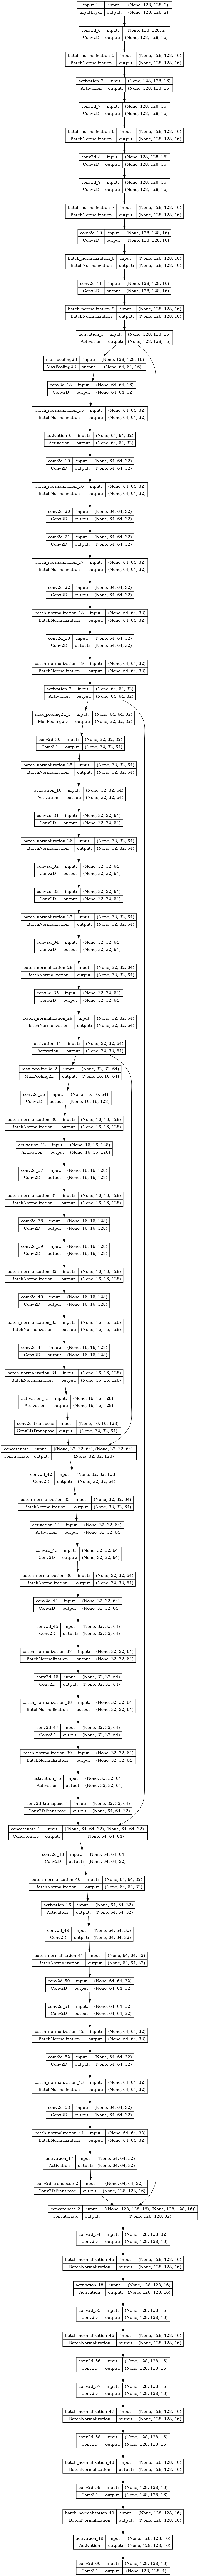

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)